In [49]:
using SpecialFunctions, Plots, ProgressMeter, LaTeXStrings, Polynomials, DataFrames, CSV, ColorSchemes, LinearAlgebra

## Definitions

We use the definition
$$S_{h,j} = \left[ \frac{\Gamma(2h)}{\Gamma(h)^2} \frac{1}{\Gamma(2h_\phi - h) \Gamma(2h_\phi + h - 1)} \right]
\frac{1}{(2h_\phi - h + j) (2h_\phi + h - 1 + j)}$$
where the term in square bracket may or may not be included, depending on what needs to be computed:
- Without this term, $S_{h, j}$ is particularly simple to evaluate. It is however singular at $h = 2h_\phi + j$, as well as at $h = 1 - 2 h_\phi$ when $j = 0$, and at $h = 0$.
- With the square bracket term, $S_{h,j}$ is regular at any value of $h \geq 0$, and it has zeros at $h = 2h_\phi + n$ with integer $n$. It can be rewritten
$$S_{h,j} = \frac{\Gamma(2h + 1)}{2\Gamma(h) \Gamma(h+1)}
\frac{(2h_\phi - h)_j (2h_\phi + h - 1)_j}{\Gamma(2h_\phi - h + j + 1) \Gamma(2h_\phi + h + j)}$$

In [2]:
gammainverse(x :: Real) = x <= 0.0 && isinteger(x) ? 0.0 : 1.0 / gamma(x)

gammainverse (generic function with 1 method)

In [3]:
S(twohϕ :: Float64, h :: Float64, j :: Int; singular_normalization=false) = (
    singular_normalization ? 1.0 / ((twohϕ - h + j) * (twohϕ + h - 1 + j))
    : gamma(2*h + 1) / 2.0 * gammainverse(h) * gammainverse(h + 1)
        * (j == 0 ? 1 : prod((twohϕ - h + i) * (twohϕ + h - 1 + i) for i = 0:j-1))
        * gammainverse(twohϕ - h + j + 1) * gammainverse(twohϕ + h + j))

S (generic function with 1 method)

With the same normalization, we have 
$$T_{h,j} = \left[ \frac{\Gamma(2h)}{\Gamma(h)^2}  \frac{1}{\Gamma(2h_\phi - h) \Gamma(2h_\phi + h - 1)} \right]
\frac{\Gamma(h)^2 \Gamma(2h_\phi - 1 + h) \Gamma(1 - 2h_\phi + h)}
{\Gamma(2h) \Gamma(2h_\phi + h + j) \Gamma(1 - 2h_\phi + h -j)}
{}_4F_3\left( \begin{array}{c}
    h,h, 2h_\phi - 1 + h, 1 - 2h_\phi + h \\ 2h, 2h_\phi + h + j, 1 - 2h_\phi + h - j
\end{array}; 1\right)$$

This can be written as an infinite sum
$$T_{h,j} = \sum_{k = 0}^\infty T_{h,j,k}$$
with
$$T_{h,j,k} = \left[ \frac{\Gamma(2h)}{\Gamma(h)^2} \frac{1}{\Gamma(2h_\phi - h) \Gamma(2h_\phi + h - 1)} \right]
\frac{\Gamma(h + k)^2 \Gamma(2h_\phi - 1 + h + k) \Gamma(1 - 2h_\phi + h + k)}
{k! \Gamma(2h + k) \Gamma(2h_\phi + h + j + k) \Gamma(1 - 2h_\phi + h - j + k)}$$

At large values of $k$, we have
$$T_{h,j,k} \sim \left[ \frac{\Gamma(2h)}{\Gamma(h)^2} \frac{1}{\Gamma(2h_\phi - h) \Gamma(2h_\phi + h - 1)} \right]
\frac{1}{k^2} \qquad (k \to \infty)$$
and the sum is therefore absolutely convergent.

The $T_{h,j,k}$ obey a simple recursion relation in $j$,
$$T_{h,j+1,k} = \frac{h - 2 h_\phi - j + k}{h + 2 h_\phi + j + k} T_{h,j,k}$$
with the initial term
$$T_{h,0,k} = \left[ \frac{\Gamma(2h)}{\Gamma(h)^2} \frac{1}{\Gamma(2h_\phi - h) \Gamma(2h_\phi + h - 1)} \right]
\frac{\Gamma(h + k)^2}{k! \Gamma(2h + k) (2h_\phi + h + k - 1)}$$

Then, for the term with $j = 0$ and integer-spaced values of $h$, there is the recursion relation in $h$
$$T_{h+1,0,k} = \left[ \frac{2(2h+1)(2 h_\phi - h - 1)}{h(2 h_\phi + h - 1)} \right] \frac{(h + k)^2 (h + 2h_\phi + k - 1)}
{(2h + k + 1) (2h + k) (2 h_\phi + h + k)} T_{h, 0, k}$$

Finally, there is a recursion relation in $k$,
$$T_{h, 0, k+1} = \frac{(h+k)^2 (2 h_\phi + h + k - 1)}{(k + 1)(2h + k)(2h_\phi + h + k)} T_{h, 0, k}$$
starting at
$$T_{h, 0, 0} = \left[ \frac{\Gamma(2h)}{\Gamma(h)^2} \frac{1}{\Gamma(2h_\phi - h) \Gamma(2h_\phi + h - 1)} \right]
\frac{\Gamma(h)^2}{\Gamma(2h) (2h_\phi + h - 1)}$$

There is a special case when $h = 1 - 2 h_\phi$. With the term in square bracket, only the term $k = 0$ is present in the sum, and we have
$$T_{h, j} = \frac{\Gamma(2h)}{j! \Gamma(2h -j) \Gamma(1 - 2h)}$$
Without the square bracket normalization, $T_{h, j}$ is singular at all $j$, unless $h = 2h_\phi = \frac{1}{2}$, in which case the terms with $j > 0$ are regular again and given by
$$T_{h, j} = \sum_{k=0}^{j-1} \frac{(-1)^{j+k+1} \sqrt{\pi} (j-1)!}{k! \left(k + \frac{1}{2} \right) \Gamma\left( j - k + \frac{1}{2} \right)}
\qquad \left( h = 2h_\phi = \tfrac{1}{2}, ~ j > 0 \right)$$

In [4]:
Thalf(j :: Int) = (j > 0 ? sum(gamma(j) * sqrt(π) * (-1)^(j+k+1) / gamma(k + 1) / (k + 1/2) / gamma(j - k + 0.5) for k=0:j-1)
    : NaN)

Thalf (generic function with 1 method)

In [5]:
[Thalf(j) for j = 0:50]

51-element Vector{Float64}:
 NaN
   3.9999999999999996
  -1.3333333333333335
   1.155555555555556
  -0.7238095238095241
   0.6679365079365076
  -0.4960076960076962
   0.46910549767692555
  -0.37713397713397834
   0.3613739927465408
  -0.30418396189293717
   0.2938468917641446
  -0.2548668971606277
   ⋮
   0.08121107393951131
  -0.07791453031163337
   0.07721811297985459
  -0.07423332783259501
   0.07360120270363452
  -0.07088764552389265
   0.07030630886048395
  -0.06780627732412532
   0.06730547882536689
  -0.06502072232063619
   0.06471592812680274
  -0.06211983876032327

In the limit $h_\to 0_+$, $T_{h, j}$ is dominated by the term $k = 0$ in the sum:
- it diverges without the normalization factor in square bracket
- with the factor, it approaches 
$$T_{0,j} = \frac{(-1)^j}{\Gamma(2h_\phi)^2}$$

In [6]:
T0(twohϕ :: Float64, j :: Int) = (-1)^j / gamma(twohϕ)^2

T0 (generic function with 1 method)

## Matrices of $S_{h,j} - T_{h,j}$

The following functions define $n_j \times n_h$ matrices whose entries are respectively given by $S_{h,j}$ and $T_{h,j}$, with $j = 0, 1, 2, \ldots, n_j-1$ and $h = h_0, h_0 + 1, \ldots, h_0 + n_h - 1$:

In [7]:
S_matrix(twohϕ :: Float64, h0 :: Float64, nj :: Int, nh :: Int = nj; singular_normalization=false) = (
    [S(twohϕ, h0 + i, j, singular_normalization=singular_normalization) for i = 0:nh-1, j = 0:nj-1])

S_matrix (generic function with 2 methods)

In [8]:
function T_matrix(twohϕ :: Float64, h0 :: Float64, nj :: Int, nh :: Int = nj; singular_normalization=false, kmax :: Int = 1000000)
    
    twohϕ > 0 || throw(DomainError(hϕ, "hϕ must be strictly positive"))
    h0 > 0 || throw(DomainError(h0, "h must be strictly positive"))

    if twohϕ + h0 == 1.0
        Th0 = [(singular_normalization ? (h0 == 0.5 ? Thalf(j) : NaN)
                : gamma(2*h0) / gamma(j + 1) * gammainverse(2*h0 - j) * gammainverse(1 - 2*h0)) for j = 0:nj-1]
        Th = T_matrix(twohϕ, h0 + 1.0, nj, nh - 1, singular_normalization=singular_normalization)
        return vcat(hcat(Th0)', Th)
    end
    
    Th00 = (singular_normalization ? gamma(h0)^2 / gamma(2 * h0) / (twohϕ + h0 - 1)
        : gammainverse(twohϕ - h0) * gammainverse(twohϕ + h0)) 
    Th0k = [Th00]
    for k = 0:kmax-1
        Th00 *= (h0 + k)^2 * (twohϕ + h0 + k - 1.) / (k + 1) / (2*h0 + k) / (twohϕ + h0 + k)
        push!(Th0k, Th00)
    end

    k = collect(0:kmax)
    Thjk = [copy(Th0k)]
    for i = 0:nh-2
        h = h0 + i
        hk = h .+ k
        Th0k .*= hk.^2 .* (hk .+ (twohϕ - 1.)) ./ (2*h .+ k) ./ ((2*h + 1.) .+ k) ./ (hk .+ twohϕ)
        if singular_normalization == false
            Th0k .*= 2 * (2*h + 1) * (twohϕ - h - 1) / h / (twohϕ + h - 1)
        end
        push!(Thjk, copy(Th0k))
    end
    Thjk = reduce(hcat, Thjk)'

    result = [sum(Thjk, dims=2)]
    h = h0 .+ collect(0:nh-1)
    hk = h .+ k'
    for j = 0:nj-2
        Thjk .*= (hk .- (j + twohϕ)) ./ ((j + twohϕ) .+ hk)
        push!(result, sum(Thjk, dims=2))
    end

    return reduce(hcat, result)
end

T_matrix (generic function with 2 methods)

**Performance tests**

Choosing a very large value of $k_\text{max}$ does not impact the computation speed very much:

In [9]:
@time T_matrix(0.5, 1.0, 10, kmax=1000)

  0.071619 seconds (224.61 k allocations: 11.943 MiB, 99.48% compilation time)


10×10 Matrix{Float64}:
    -0.441112     -0.19519      -0.0166994  …     -0.00107297     -0.00278127
     1.16924       0.907479      0.478981          0.0403987       0.0315606
    -3.66511      -3.24827      -2.35949          -0.316403       -0.250455
    12.34         11.5105        9.50714           1.89637         1.52383
   -43.1543      -41.2554      -36.345            -9.86421        -8.06452
   154.401       149.62        136.736      …     46.9875         39.1125
  -560.686      -547.794      -512.122          -210.999        -178.749
  2056.8        2020.22       1917.14            909.242         783.002
 -7599.31      -7491.28      -7183.05          -3803.95        -3324.81
 28222.3       27893.2       26945.3           15573.1         13792.2

In [10]:
@time T_matrix(0.5, 1.0, 10, kmax=10000)

  0.001874 seconds (155 allocations: 3.378 MiB)


10×10 Matrix{Float64}:
    -0.441255     -0.195333     -0.0168421  …     -0.00121109     -0.00291811
     1.17181       0.910047      0.481545          0.0428795       0.0340186
    -3.68645      -3.26959      -2.38078          -0.33701        -0.270872
    12.4788       11.6492        9.64564           2.03042         1.65665
   -43.953       -42.0537      -37.1419          -10.6356         -8.82886
   158.668       153.885       140.994      …     51.1092         43.1966
  -582.374      -569.471      -533.763          -231.949        -199.508
  2163.13       2126.48       2023.24           1011.96          884.782
 -8106.49      -7998.18      -7689.14          -4293.95        -3810.36
 30590.1       30259.6       29307.9           17860.9         16059.3

In [11]:
@time T_matrix(0.5, 1.0, 10, kmax=100000)

  0.038999 seconds (159 allocations: 32.353 MiB, 20.80% gc time)


10×10 Matrix{Float64}:
    -0.44127     -0.195347     -0.0168564  …     -0.00122536     -0.00293237
     1.17206      0.910304      0.481802          0.0431364       0.0342752
    -3.6886      -3.27174      -2.38293          -0.339149       -0.273009
    12.4928      11.6632        9.65966           2.04439         1.67061
   -44.0341     -42.1348      -37.223           -10.7164         -8.90958
   159.104      154.32        141.429      …     51.5434         43.6304
  -584.604     -571.701      -535.993          -234.171        -201.728
  2174.15      2137.5        2034.25           1022.93          895.75
 -8159.5      -8051.19      -7742.14          -4346.77        -3863.14
 30839.9      30509.5       29557.8           18109.9         16308.1

In [12]:
@time T_matrix(0.5, 1.0, 10)

  0.467749 seconds (165 allocations: 322.595 MiB, 40.04% gc time)


10×10 Matrix{Float64}:
    -0.441271     -0.195348     -0.0168579  …     -0.00122679     -0.0029338
     1.17209       0.91033       0.481828          0.0431621       0.0343009
    -3.68882      -3.27196      -2.38314          -0.339364       -0.273224
    12.4942       11.6646        9.66106           2.0458          1.67201
   -44.0422      -42.1429      -37.2311          -10.7245         -8.9177
   159.148       154.364       141.473      …     51.5871         43.674
  -584.828      -571.924      -536.216          -234.394        -201.952
  2175.25       2138.61       2035.36           1024.04          896.856
 -8164.83      -8056.52      -7747.46          -4352.1         -3868.46
 30865.1       30534.6       29582.9           18135.0         16333.2

However, the computation time increases significantly with $n$, and appears to be $\mathcal{O}(n^2)$:

In [13]:
@time T_matrix(0.5, 1.0, 20);

  1.233043 seconds (286 allocations: 627.780 MiB, 28.17% gc time)


In [14]:
@time T_matrix(0.5, 1.0, 50);

  5.009449 seconds (648 allocations: 1.507 GiB, 7.91% gc time)


In [15]:
@time T_matrix(0.5, 1.0, 100);

 19.191844 seconds (1.25 k allocations: 2.997 GiB, 3.04% gc time)


The computation time is independent of the choice of parameters:

In [16]:
@time T_matrix(1.0, 1.2, 100);

 19.400322 seconds (1.25 k allocations: 2.997 GiB, 3.03% gc time)


## Asymptotics

$S$ and $T$ have identical asymptotics at large $j$, for any fixed $h$,
$$\lim_{j \to \infty} \frac{T_{h,j}}{S_{h,j}} = +1$$
but opposite asymptotics at large $h$, for any fixed $j$:
$$\lim_{h \to \infty} \frac{T_{h,j}}{S_{h,j}} = -1$$


In [17]:
# TS_ratio = T_matrix(0.5, 1.0, 20) ./ S_matrix(0.5, 1.0, 20)
TS_ratio = T_matrix(0.5, 1.0, 20, singular_normalization=true) ./ S_matrix(0.5, 1.0, 20, singular_normalization=true)

20×20 Matrix{Float64}:
 -0.693147   0.920558   0.397204  …   1.49648     0.49795     1.49705
 -0.920556  -0.397206   0.294332      0.983258    0.985364    0.986437
 -0.96573   -0.719541  -0.224606      0.956706    0.961213    0.96504
 -0.981291  -0.841351  -0.511014      0.917871    0.92633     0.933545
 -0.988304  -0.898985  -0.670434      0.868409    0.881691    0.893079
 -0.992017  -0.930392  -0.765238  …   0.810033    0.828702    0.844804
 -0.994204  -0.949256  -0.825263      0.744595    0.768904    0.79001
 -0.995593  -0.96142   -0.865321      0.673959    0.703877    0.730042
 -0.996525  -0.969696  -0.893235      0.599898    0.635156    0.666227
 -0.997177  -0.97557   -0.913393      0.524017    0.564162    0.599822
 -0.997647  -0.979881  -0.928389  …   0.447703    0.49216     0.531967
 -0.997995  -0.983135  -0.939826      0.37211     0.420231    0.463666
 -0.998256  -0.985646  -0.948736      0.298152    0.349267    0.39577
 -0.998455  -0.987621  -0.955803      0.226527    0.279975

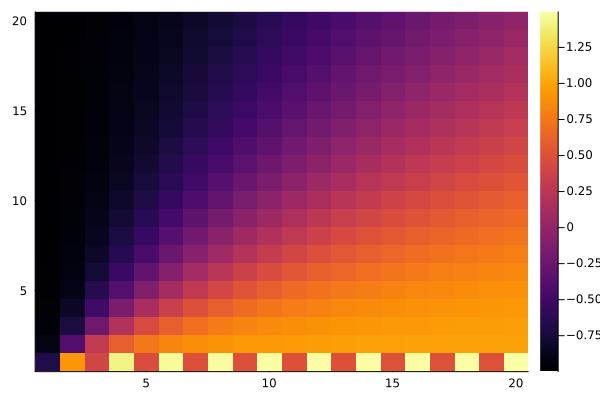

In [18]:
heatmap(TS_ratio)

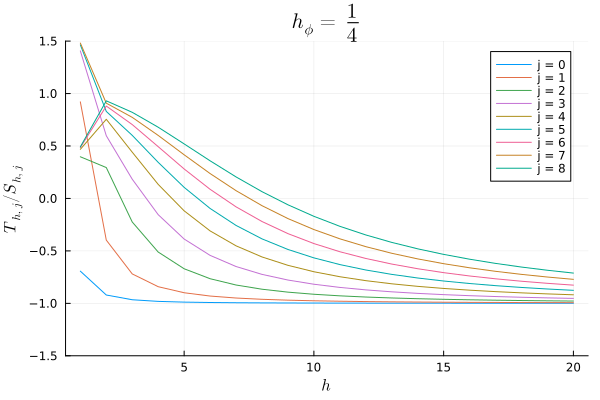

In [19]:
plot()
for j = 0:8
    plot!(TS_ratio[:,j+1], label="j = $j")
end
xlabel!(L"h")
ylims!(-1.5, 1.5)
ylabel!(L"T_{h,j} / S_{h,j}")
title!(L"h_\phi = \frac{1}{4}")

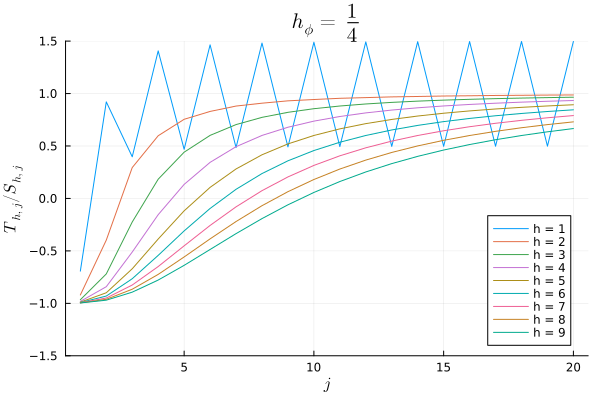

In [20]:
plot()
for h = 1:9
    plot!(TS_ratio[h,:], label="h = $h")
end
xlabel!(L"j")
ylims!(-1.5, 1.5)
ylabel!(L"T_{h,j} / S_{h,j}")
title!(L"h_\phi = \frac{1}{4}")

We define $G$ as the difference between $S$ and $T$
$$G_{h,j} = S_{h,j} - T_{h,j}$$

In [21]:
G_matrix(twohϕ :: Float64, h0 :: Float64, nj :: Int, nh :: Int = nj; singular_normalization=false, kmax :: Int = 1000000) = (
    S_matrix(twohϕ, h0, nj, nh, singular_normalization=singular_normalization)
    - T_matrix(twohϕ, h0, nj, nh, singular_normalization=singular_normalization, kmax=kmax))

G_matrix (generic function with 2 methods)

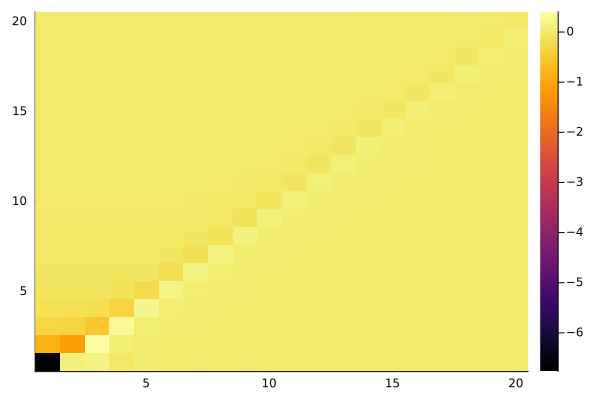

In [22]:
heatmap(G_matrix(0.5, 1.0, 20, singular_normalization=true))

## Tables of values

In [24]:
hϕ_table = collect(0.05:0.05:1.0)

20-element Vector{Float64}:
 0.05
 0.1
 0.15
 0.2
 0.25
 0.3
 0.35
 0.4
 0.45
 0.5
 0.55
 0.6
 0.65
 0.7
 0.75
 0.8
 0.85
 0.9
 0.95
 1.0

In [25]:
jmax = 50
hmax = 10

Δh = 0.01

h0_table = collect(Δh : Δh : 1)
length(h0_table)

100

In [26]:
for hϕ ∈ hϕ_table
    csv_file = "data/G_$(hϕ).csv"
    if isfile(csv_file)
        G_df = CSV.read(csv_file, DataFrame)
        if size(G_df)[1] >= hmax * length(h0_table) + 1 && size(G_df)[2] >= jmax + 2
            continue
        end
    end
    println("hϕ = $(hϕ)")
    G_df = reduce(vcat, @showprogress [reduce(hcat, [DataFrame("h" => [h0 + i for i = 0:hmax-1]),
            DataFrame(G_matrix(2*hϕ, h0, jmax + 1, hmax), string.(0:jmax))])
            for h0 ∈ h0_table])
    append!(G_df,DataFrame(vcat(["h" => 0.0], [string(j) => -T0(2*hϕ, j) for j = 0:jmax])))
    sort!(G_df, "h")
    CSV.write(csv_file, G_df)
end

## Plots of $S_{h,j} - T_{h,j}$

In [27]:
G_df = CSV.read("data/G_0.25.csv", DataFrame, select=["h", "0", "1", "2", "3"])

Row,h,0,1,2,3
,Float64,Float64,Float64,Float64,Float64
1,0.0,-0.31831,0.31831,-0.31831,0.31831
2,0.01,-0.312778,0.305603,-0.301749,0.299259
3,0.02,-0.306958,0.293116,-0.285758,0.28106
4,0.03,-0.300847,0.280855,-0.270327,0.263689
5,0.04,-0.294443,0.268823,-0.25545,0.24712
6,0.05,-0.287743,0.257023,-0.241116,0.231328
7,0.06,-0.280743,0.24546,-0.227318,0.216289
8,0.07,-0.273442,0.234136,-0.214045,0.201978
9,0.08,-0.265838,0.223056,-0.201289,0.188373


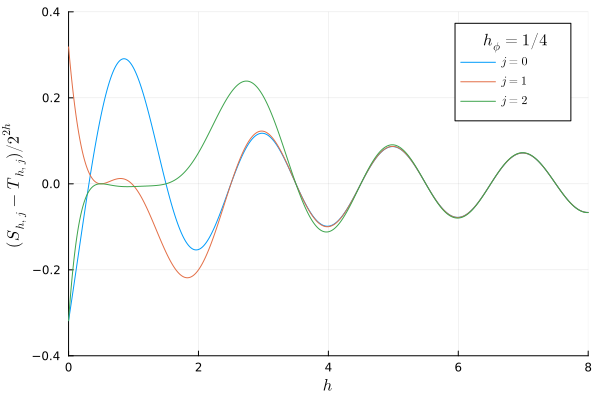

In [68]:
plot(legendtitle=L"h_\phi = 1/4")
for j = 0:2
    h = G_df[!, "h"]
    plot!(h, 0.25.^h .* G_df[!, string(j)], label=L"j = %$j")
end
xlims!(0, 8)
ylims!(-0.4, 0.4)
xlabel!(L"h")
ylabel!(L"( S_{h,j} - T_{h,j} ) / 2^{2h}")

In [69]:
# savefig("S_minus_T_example.pdf")

## β functionals: zeros at double-trace dimensions $h = 2h_\phi + 2n (+1)$

In [35]:
function βFcoefficients(twohϕ :: Float64, n :: Int)
    halfn = (n+1) ÷ 2
    coeffs = zeros(n, halfn)
    G = G_matrix(twohϕ, twohϕ + 1, 2*n - 1, singular_normalization=true)[1:2:n, 1:2:n]
    coeffs[1:2:n, 1:halfn] = inv(G)
    return coeffs
end

βFcoefficients (generic function with 1 method)

In [37]:
# βFcoeffs = Dict{String, Vector{Float64}}()
# βF = Dict{String, Vector{Float64}}()
# @showprogress for hϕ ∈ hϕ_table
#     c = βFcoefficients(2 * hϕ, jmax+1)
#     βFcoeffs[string(hϕ)] = c[:, 1]
#     G_df = CSV.read("data/G_$(hϕ).csv", DataFrame)
#     h = G_df[!, "h"]
#     if "h" ∉ keys(βF)
#         βF["h"] = h
#     end
#     βF[string(hϕ)] = Matrix(G_df[!, [string(j) for j = 0:jmax]]) * c[:, 1]
# end
# CSV.write("data/beta_F_coeffs.csv", DataFrame(βFcoeffs))
# CSV.write("data/beta_F.csv", DataFrame(βF));

In [38]:
βF_coeffs = CSV.read("data/beta_F_coeffs.csv", DataFrame)

Row,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,-0.100098,-0.200691,-0.302072,-0.404398,-0.507741,-0.612123,-0.717536,-0.823952,-0.931333,-1.03964,-1.14881,-1.25882,-1.36961,-1.48114,-1.59337,-1.70625,-1.81975,-1.93383,-2.04846,-2.1636
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0881842,0.173917,0.257783,0.340186,0.421409,0.50166,0.581091,0.659817,0.737927,0.815489,0.892558,0.96918,1.04539,1.12122,1.19669,1.27183,1.34666,1.42118,1.49543,1.5694
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0077375,0.0171072,0.0278607,0.0397952,0.0527427,0.0665635,0.0811397,0.0963718,0.112175,0.128476,0.145213,0.162332,0.179784,0.19753,0.215533,0.233762,0.252188,0.270788,0.28954,0.308424
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.00209087,0.00477654,0.00801524,0.0117673,0.0159954,0.0206644,0.0257416,0.0311967,0.0370015,0.0431297,0.0495571,0.0562615,0.063222,0.0704195,0.0778364,0.0854562,0.0932639,0.101246,0.109388,0.11768
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000842654,0.00195494,0.00332854,0.00495429,0.0068225,0.00892321,0.0112464,0.0137819,0.0165201,0.019451,0.0225655,0.0258544,0.029309,0.0329208,0.0366818,0.0405842,0.0446209,0.0487847,0.0530689,0.0574673


In [39]:
βF = CSV.read("data/beta_F.csv", DataFrame)

Row,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0,h
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,6.21791e-7,6.43244e-6,2.67553e-5,7.50717e-5,0.000167655,0.000321382,0.000551135,0.000867284,0.00127369,0.00176653,0.0023341,0.00295762,0.00361276,0.0042718,0.00490595,0.00548773,0.00599292,0.0064022,0.00670207,0.00688532,0.0
2,0.000106755,0.00060365,0.00169236,0.00354218,0.00626134,0.00987815,0.014334,0.0194881,0.025132,0.0310108,0.0368478,0.0423693,0.0473265,0.0515126,0.0547747,0.0570189,0.0582106,0.0583701,0.0575642,0.0558964,0.01
3,0.000161236,0.00107111,0.0031247,0.00665087,0.0118557,0.0187865,0.0273191,0.0371695,0.0479239,0.0590822,0.0701068,0.0804715,0.0897034,0.0974159,0.10333,0.107281,0.109222,0.109208,0.107382,0.103955,0.02
4,0.00016539,0.00141169,0.00432829,0.00940725,0.0169585,0.0270553,0.0395163,0.0539222,0.0696609,0.0859927,0.102123,0.117276,0.130755,0.141993,0.150582,0.156285,0.159038,0.158925,0.156165,0.151069,0.03
5,0.000120527,0.00162822,0.00530757,0.0118174,0.021577,0.0346933,0.0509356,0.0697568,0.090354,0.111754,0.132909,0.152795,0.170494,0.185256,0.196543,0.204042,0.207667,0.207532,0.203921,0.197248,0.04
6,2.7944e-5,0.00172352,0.00606695,0.0138872,0.0257188,0.0417093,0.0615865,0.0846839,0.110015,0.136377,0.162475,0.187041,0.208931,0.227216,0.241223,0.250562,0.255121,0.255038,0.250661,0.242499,0.05
7,-0.000111071,0.00170036,0.00661082,0.0156226,0.0293912,0.0481118,0.0714788,0.0987139,0.128653,0.159873,0.190834,0.220023,0.246078,0.267883,0.284633,0.295855,0.301408,0.301451,0.296391,0.286831,0.06
8,-0.000295241,0.00156152,0.00694349,0.0170296,0.0326014,0.0539094,0.080622,0.111857,0.146281,0.182254,0.217996,0.251753,0.281944,0.307268,0.326782,0.33993,0.346538,0.34678,0.341121,0.33025,0.07
9,-0.000523292,0.00130976,0.00706931,0.0181139,0.0353569,0.0591105,0.0890255,0.124124,0.162909,0.20353,0.243972,0.282243,0.316541,0.345381,0.367682,0.382798,0.39052,0.391033,0.384857,0.372764,0.08


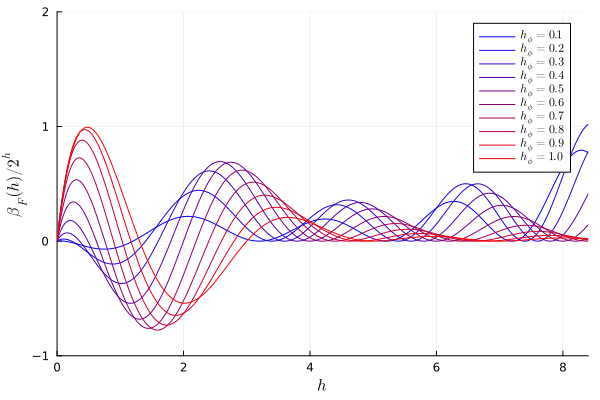

In [122]:
plot(palette = ColorScheme(range(colorant"blue", colorant"red", length=10)))
for hϕ = 0.1:0.1:1
    h = βF[!, "h"]
    plot!(h, 0.5.^h .* βF[!, string(hϕ)], label=L"h_\phi = %$hϕ")
end
xlims!(0,8.4)
ylims!(-1,2)
xlabel!(L"h")
ylabel!(L"\beta_F(h) / 2^h")

In [124]:
# savefig("beta_F.pdf")

In [56]:
function βBcoefficients(twohϕ :: Float64, n :: Int)
    halfn = n ÷ 2
    coeffs = zeros(n, halfn)
    G = G_matrix(twohϕ, twohϕ + 1, 2*n - 1, singular_normalization=true)[2:2:n, 2:2:n]
    coeffs[2:2:n, 1:halfn] = inv(G)
    return coeffs
end

βBcoefficients (generic function with 1 method)

In [57]:
# βBcoeffs = Dict{String, Vector{Float64}}()
# βB = Dict{String, Vector{Float64}}()
# @showprogress for hϕ ∈ hϕ_table
#     c = βBcoefficients(2 * hϕ, jmax+1)
#     βBcoeffs[string(hϕ)] = c[:, 1]
#     G_df = CSV.read("data/G_$(hϕ).csv", DataFrame)
#     h = G_df[!, "h"]
#     if "h" ∉ keys(βB)
#         βB["h"] = h
#     end
#     βB[string(hϕ)] = Matrix(G_df[!, [string(j) for j = 0:jmax]]) * c[:, 1]
# end
# CSV.write("data/beta_B_coeffs.csv", DataFrame(βBcoeffs))
# CSV.write("data/beta_B.csv", DataFrame(βB));

In [58]:
βB_coeffs = CSV.read("data/beta_B_coeffs.csv", DataFrame)

Row,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.05598,-1.19509,-1.33047,-1.46302,-1.59337,-1.72201,-1.8493,-1.97552,-2.10089,-2.22557,-2.3497,-2.47339,-2.59673,-2.71978,-2.84261,-2.96526,-3.08778,-3.21019,-3.33253,-3.45482
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.830512,0.928005,1.02093,1.11026,1.19669,1.28076,1.36289,1.44338,1.52249,1.60042,1.67733,1.75336,1.82863,1.90321,1.97719,2.05063,2.1236,2.19613,2.26827,2.34005
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.128909,0.150647,0.172341,0.193974,0.215532,0.237007,0.258394,0.279691,0.300894,0.322004,0.343022,0.363948,0.384784,0.405532,0.426194,0.446772,0.467268,0.487685,0.508025,0.52829
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.04334,0.0516688,0.0602112,0.0689406,0.0778343,0.0868723,0.0960375,0.105315,0.114691,0.124154,0.133694,0.143302,0.15297,0.162691,0.172458,0.182265,0.192109,0.201983,0.211884,0.221808
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
βB = CSV.read("data/beta_B.csv", DataFrame)

Row,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0,h
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,-2.17127e-5,-0.000116077,-0.000332198,-0.000720569,-0.00132543,-0.00217759,-0.00328887,-0.00464898,-0.00622524,-0.00796486,-0.00979952,-0.0116513,-0.0134394,-0.0150864,-0.0165242,-0.017698,-0.0185692,-0.0191166,-0.0193362,-0.0192393,0.0
2,-0.000302891,-0.00156102,-0.00405748,-0.00794656,-0.0132399,-0.0198085,-0.0274011,-0.0356743,-0.0442289,-0.0526488,-0.0605355,-0.0675387,-0.0733771,-0.0778515,-0.0808497,-0.0823431,-0.0823784,-0.081065,-0.0785596,-0.075051,0.01
3,-0.000457862,-0.00267038,-0.00717836,-0.0142519,-0.0238862,-0.0358115,-0.0495328,-0.0643917,-0.0796383,-0.0945049,-0.108271,-0.120318,-0.130163,-0.137482,-0.142113,-0.144046,-0.143403,-0.140416,-0.135391,-0.128688,0.02
4,-0.000512279,-0.00348026,-0.00974221,-0.0196952,-0.0333341,-0.0502663,-0.0697721,-0.090896,-0.112553,-0.133635,-0.153108,-0.170089,-0.183894,-0.194071,-0.200402,-0.202887,-0.201717,-0.197234,-0.18989,-0.180202,0.03
5,-0.000490681,-0.0040254,-0.0117948,-0.0243337,-0.0416514,-0.0632505,-0.0882049,-0.11528,-0.143069,-0.170138,-0.195147,-0.21695,-0.234665,-0.247709,-0.255801,-0.258945,-0.257392,-0.251587,-0.242114,-0.229645,0.04
6,-0.000416493,-0.00433918,-0.0133802,-0.0282223,-0.0489037,-0.0748393,-0.104915,-0.137632,-0.171282,-0.204112,-0.234484,-0.260998,-0.28257,-0.298484,-0.308393,-0.312297,-0.310498,-0.303535,-0.29212,-0.277066,0.05
7,-0.000312039,-0.00445362,-0.014541,-0.0314144,-0.0551548,-0.0851058,-0.119983,-0.158042,-0.197282,-0.235649,-0.271215,-0.302324,-0.327698,-0.346482,-0.358259,-0.363018,-0.361104,-0.353142,-0.339962,-0.322514,0.06
8,-0.000198552,-0.00439946,-0.0153183,-0.0339616,-0.0604664,-0.0941213,-0.133488,-0.176593,-0.221161,-0.264843,-0.305431,-0.341022,-0.370139,-0.391789,-0.405478,-0.411181,-0.409276,-0.400468,-0.385695,-0.366037,0.07
9,-9.61782e-5,-0.00420608,-0.0157516,-0.0359137,-0.0648984,-0.101955,-0.145507,-0.193369,-0.243004,-0.291783,-0.337223,-0.37718,-0.409977,-0.434485,-0.450128,-0.456857,-0.45508,-0.445572,-0.429372,-0.40768,0.08


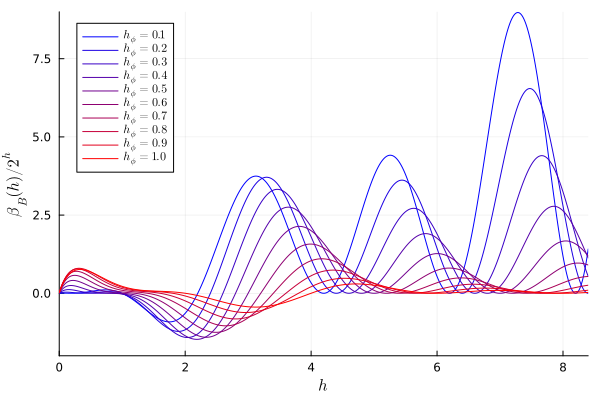

In [126]:
plot(palette = ColorScheme(range(colorant"blue", colorant"red", length=10)))
for hϕ = 0.1:0.1:1
    h = βB[!, "h"]
    plot!(h, -1 .* 0.5.^h .* βB[!, string(hϕ)], label=legendtitle = L"h_\phi = %$hϕ")
end
xlims!(0,8.4)
ylims!(-2, 9)
xlabel!(L"h")
ylabel!(L"\beta_B(h) / 2^h")

In [128]:
# savefig("beta_B.pdf")

## γ functionals: zeros at integer dimensions

In [129]:
function γcoefficients(twohϕ :: Float64, n :: Int)
    G = G_matrix(twohϕ, 1.0, n, singular_normalization=true)
    coeffs = inv(G)
    γ0 = coeffs' * [(-1)^i for i = 1:n] ./ gamma(twohϕ)^2
    return coeffs * Diagonal(γ0.^-1)
end

γcoefficients (generic function with 1 method)

In [130]:
hϕ_table_noint = filter((hϕ) -> !isinteger(2*hϕ), hϕ_table)

18-element Vector{Float64}:
 0.05
 0.1
 0.15
 0.2
 0.25
 0.3
 0.35
 0.4
 0.45
 0.55
 0.6
 0.65
 0.7
 0.75
 0.8
 0.85
 0.9
 0.95

In [131]:
# hmax = 25
# @showprogress for hϕ ∈ hϕ_table_noint
#     γcoeffs = γcoefficients(2 * hϕ, jmax + 1)[:, 1:hmax]
#     CSV.write("data/gamma_coeffs_$(hϕ).csv", DataFrame(γcoeffs, string.(1:hmax)))
#     G_df = CSV.read("data/G_$(hϕ).csv", DataFrame)
#     h = G_df[!, "h"]
#     γ = Matrix(G_df[!, [string(j) for j = 0:jmax]]) * γcoeffs
#     γ_df = DataFrame(γ, string.(1:hmax))
#     γ_df[!, "h"] = h
#     CSV.write("data/gamma_$(hϕ).csv", γ_df)
# end

In [132]:
hϕ = 0.25

0.25

In [133]:
γ_coeffs = CSV.read("data/gamma_coeffs_$hϕ.csv", DataFrame)

Row,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,-1.82779,3.50545e-8,-0.073112,2.10324e-7,-0.022566,5.25842e-7,-0.0108165,9.81796e-7,-0.00632619,1.57873e-6,-0.00414698,2.31782e-6,-0.00292761,3.20132e-6,-0.00217746,4.23301e-6,-0.00168363,5.41886e-6,-0.00134162,6.76787e-6,-0.00109526,8.29314e-6,-0.00091218,1.00133e-5,-0.000772671
2,1.47531,1.98451,-0.637372,0.334098,-0.189872,0.137048,-0.0907475,0.0741245,-0.0530582,0.0463408,-0.0347883,0.0316919,-0.0245718,0.0230437,-0.0182912,0.0175216,-0.014161,0.013787,-0.011305,0.0111484,-0.00925249,0.00921968,-0.00773225,0.00777147,-0.00657923
3,0.208832,-1.37313,-2.21638,0.712361,-0.412784,0.266546,-0.190981,0.142368,-0.110905,0.0887313,-0.0725577,0.0606222,-0.0512025,0.044064,-0.0380965,0.0335012,-0.0294845,0.0263612,-0.0235314,0.0213185,-0.0192534,0.0176336,-0.0160844,0.0148676,-0.0136802
4,0.0668573,-0.297963,1.81594,2.06874,-0.74384,0.430556,-0.298356,0.217663,-0.168925,0.133863,-0.109697,0.0910419,-0.0771925,0.0660497,-0.0573617,0.0501714,-0.0443664,0.03946,-0.0353961,0.0319031,-0.0289549,0.0263845,-0.0241857,0.0222439,-0.0205683
5,0.0292967,-0.121834,0.46747,-1.79204,-2.11716,0.72626,-0.443735,0.307695,-0.233379,0.182422,-0.148519,0.122589,-0.10373,0.0885012,-0.0768265,0.0670701,-0.0593233,0.0526871,-0.0472862,0.0425681,-0.0386609,0.0351903,-0.0322823,0.02966,-0.027448
6,0.0153125,-0.0623262,0.216855,-0.498911,1.89445,2.06103,-0.731078,0.440504,-0.315254,0.239238,-0.191654,0.156594,-0.131709,0.111876,-0.0968669,0.0843734,-0.0745392,0.0661127,-0.0593035,0.0533395,-0.0484334,0.0440575,-0.0404154,0.0371139,-0.0343483
7,0.00897044,-0.0362036,0.121698,-0.248147,0.551075,-1.88161,-2.08004,0.71829,-0.442994,0.315209,-0.244226,0.195707,-0.16266,0.137077,-0.11807,0.102451,-0.0902778,0.0799078,-0.0715799,0.0643035,-0.0583442,0.0530321,-0.0486267,0.0446311,-0.041295
8,0.00569298,-0.0228867,0.0757836,-0.147504,0.286014,-0.562417,1.92583,2.05071,-0.719261,0.438425,-0.317198,0.245035,-0.199299,0.165654,-0.141392,0.12191,-0.106947,0.0943486,-0.0843131,0.075599,-0.0684981,0.0621896,-0.0569758,0.0522552,-0.0483236
9,0.00383354,-0.0153808,0.0505497,-0.0962623,0.176577,-0.300149,0.586352,-1.91814,-2.06087,0.710625,-0.438683,0.315434,-0.246749,0.20032,-0.168408,0.143717,-0.125176,0.109855,-0.0977954,0.0874325,-0.079046,0.0716407,-0.0655466,0.0600494,-0.055484


In [134]:
γ = CSV.read("data/gamma_$hϕ.csv", DataFrame)

Row,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,h
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.973722,0.956054,0.94304,0.938343,0.932302,0.929359,0.925569,0.923395,0.920662,0.91893,0.916805,0.915362,0.913629,0.912391,0.910932,0.909846,0.908588,0.907621,0.906517,0.905645,0.904662,0.903867,0.902983,0.902252,0.901449,0.01
3,0.947164,0.913158,0.888398,0.879628,0.868289,0.862851,0.855796,0.851804,0.846749,0.843583,0.839669,0.837042,0.833863,0.831615,0.828947,0.826982,0.824688,0.822941,0.820933,0.819359,0.817577,0.816145,0.814544,0.81323,0.811779,0.02
4,0.920325,0.871313,0.836017,0.82375,0.807805,0.800278,0.790439,0.784949,0.77794,0.773606,0.768206,0.764622,0.760253,0.757196,0.753541,0.750875,0.747741,0.745376,0.74264,0.740515,0.738091,0.736161,0.733988,0.73222,0.730255,0.03
5,0.893207,0.830518,0.785843,0.770611,0.7507,0.741452,0.729266,0.722563,0.713934,0.708668,0.70205,0.697711,0.692378,0.688688,0.68424,0.68103,0.677227,0.674387,0.671075,0.668528,0.6656,0.663291,0.660672,0.65856,0.656195,0.04
6,0.865811,0.790774,0.737819,0.720113,0.696826,0.686189,0.672054,0.664394,0.654444,0.648452,0.640858,0.63594,0.629841,0.625672,0.620602,0.616985,0.612663,0.609469,0.605715,0.602856,0.599544,0.596957,0.594001,0.591639,0.588974,0.05
7,0.838139,0.752081,0.69189,0.67216,0.646043,0.634315,0.618591,0.610199,0.599196,0.592663,0.584303,0.57896,0.572273,0.567756,0.562216,0.558307,0.553597,0.550154,0.546072,0.542996,0.539404,0.536626,0.533425,0.530893,0.528013,0.06
8,0.810192,0.714436,0.648002,0.62666,0.598214,0.585662,0.568675,0.55975,0.547933,0.541017,0.532081,0.526445,0.519324,0.514575,0.508693,0.504594,0.499608,0.496005,0.491694,0.488482,0.484698,0.481801,0.478437,0.475801,0.472778,0.07
9,0.781974,0.677841,0.606098,0.583521,0.553205,0.540067,0.52211,0.512828,0.500409,0.49325,0.483902,0.478088,0.470668,0.465783,0.459675,0.455469,0.450305,0.446617,0.442164,0.438883,0.434981,0.432028,0.428566,0.425883,0.422778,0.08


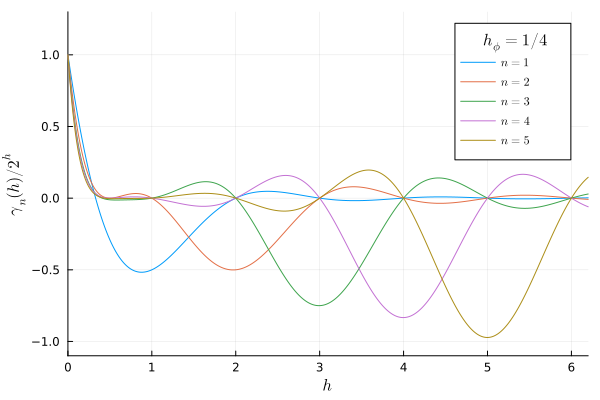

In [142]:
plot(legendtitle = L"h_\phi = 1/4")
for n = 1:5
    plot!(γ[!, "h"], 0.25.^γ[!, "h"] .* γ[!, string(n)], label=L"n = %$n")
end
xlims!(0,6.2)
ylims!(-1.1, 1.3)
xlabel!(L"h")
ylabel!(L"\gamma_n(h) / 2^h")

In [144]:
# savefig("gamma_n.pdf")

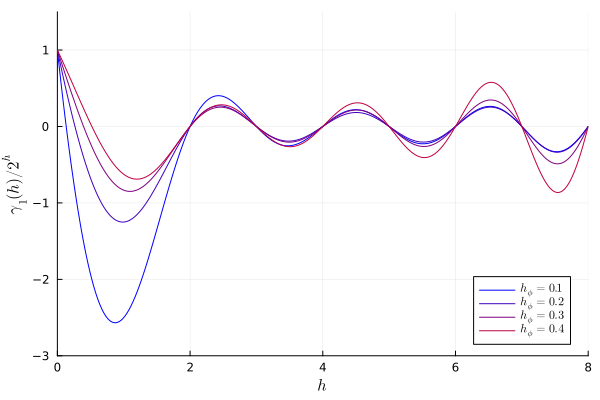

In [148]:
plot(palette = ColorScheme(range(colorant"blue", colorant"red", length=5)))
for hϕ = 0.1:0.1:0.4
    γ = CSV.read("data/gamma_$(hϕ).csv", DataFrame)
    plot!(γ[!, "h"], 0.5.^γ[!, "h"] .* γ[!, "1"], label=L"h_\phi = %$hϕ")
end
xlims!(0,8)
ylims!(-3, 1.5)
xlabel!(L"h")
ylabel!(L"\gamma_1(h) / 2^h")

In [150]:
# savefig("gamma_1.pdf")

$\gamma_n(h)$ is zero at every integer value of $h$, except
- when $h = 0$, it is equal to $1$
- when $h = n$, it is equal to
$$\gamma_n(n) = \sum_{j=0}^\infty c_{n,j} \left( S_{n, j} - T_{n, j} \right)$$

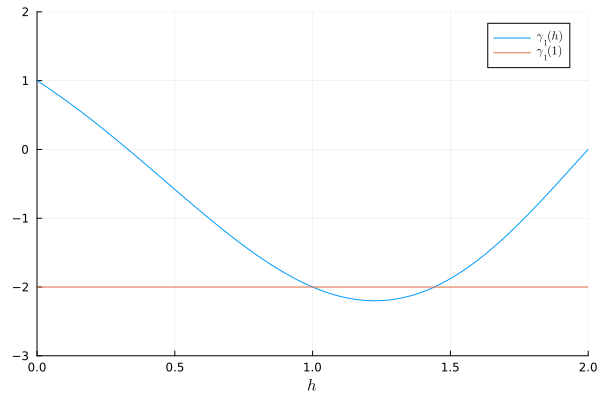

In [218]:
hϕ = 0.25
n = 1

γ_coeffs = CSV.read("data/gamma_coeffs_$(hϕ).csv", DataFrame)
γ = CSV.read("data/gamma_$(hϕ).csv", DataFrame)

γn = (G_matrix(2*hϕ, Float64(n), jmax + 1, 1) * γ_coeffs[!, string(n)])[1]

plot(γ[!, "h"], γ[!, string(n)], label=L"\gamma_1(h)")
plot!([0,10], [γn,γn], label=L"\gamma_1(1)")
xlims!(0, 2)
xlabel!(L"h")
ylims!(-3, 2)

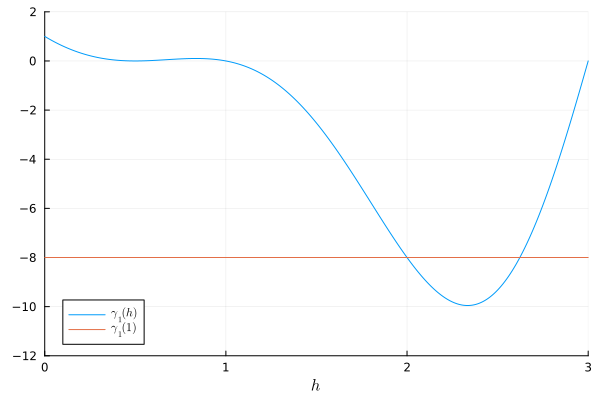

In [219]:
hϕ = 0.25
n = 2

γ_coeffs = CSV.read("data/gamma_coeffs_$(hϕ).csv", DataFrame)
γ = CSV.read("data/gamma_$(hϕ).csv", DataFrame)

γn = (G_matrix(2*hϕ, Float64(n), jmax + 1, 1) * γ_coeffs[!, string(n)])[1]

plot(γ[!, "h"], γ[!, string(n)], label=L"\gamma_1(h)")
plot!([0,10], [γn,γn], label=L"\gamma_1(1)")
xlims!(0, 3)
xlabel!(L"h")
ylims!(-12, 2)

If there are only operators with integer dimension in the OPE $\phi \times \phi$, the value $\gamma_n(n)$ gives the inverse of the corresponding OPE coefficient:

In [220]:
OPE_coeffs = Dict{Float64, Vector{Float64}}()

@showprogress for hϕ ∈ hϕ_table_noint
    γ = CSV.read("data/gamma_$(hϕ).csv", DataFrame)
    γ_coeffs = CSV.read("data/gamma_coeffs_$(hϕ).csv", DataFrame)
    γn = diag(G_matrix(2*hϕ, 1.0, jmax + 1, hmax) * Matrix(γ_coeffs))
    OPE_coeffs[hϕ] = -1 ./ γn
end
OPE_coeffs


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47

Dict{Float64, Vector{Float64}} with 18 entries:
  0.95 => [-3281.04, -1311.37, -398.282, -111.046, -30.173, -8.00661, -2.10553,…
  0.3  => [0.599998, 0.180002, 0.0359991, 0.00840033, 0.0019336, 0.000460076, 0…
  0.45 => [0.899563, 0.405262, 0.121403, 0.0341185, 0.00925072, 0.00247384, 0.0…
  0.25 => [0.5, 0.125, 0.0208332, 0.00468755, 0.00100445, 0.000232521, 5.28423e…
  0.35 => [0.699985, 0.245012, 0.0571613, 0.0140894, 0.0034416, 0.00084902, 0.0…
  0.7  => [100.127, -8.89275, 5.06463, -0.415976, 0.298105, -0.0149621, 0.01922…
  0.85 => [-5603.33, -1119.56, -344.825, -72.4932, -20.1607, -4.45978, -1.20051…
  0.15 => [0.3, 0.045, 0.0045, 0.0010875, 0.000180963, 4.35724e-5, 8.39555e-6, …
  0.2  => [0.4, 0.08, 0.0106667, 0.00240001, 0.000466283, 0.000107277, 2.2951e-…
  0.9  => [-4160.18, -1246.97, -359.733, -91.099, -24.0663, -6.03392, -1.556, -…
  0.65 => [9.40608, -0.776218, 0.866044, 0.0277066, 0.0733897, 0.00723429, 0.00…
  0.8  => [-15777.6, -1576.64, -735.682, -94.3806, -37.7586, 

In the case $h_\phi = \frac{1}{4}$, we can guess rational values with high precision:

In [221]:
[1/2, 1/8, 1/48, 3/640, 9/8960, 5/21504] ./ OPE_coeffs[0.25][1:6]

6-element Vector{Float64}:
 1.000000437149579
 0.9999982513991684
 1.0000056830610735
 0.9999895080431817
 1.0000179254440253
 0.9999737656011026

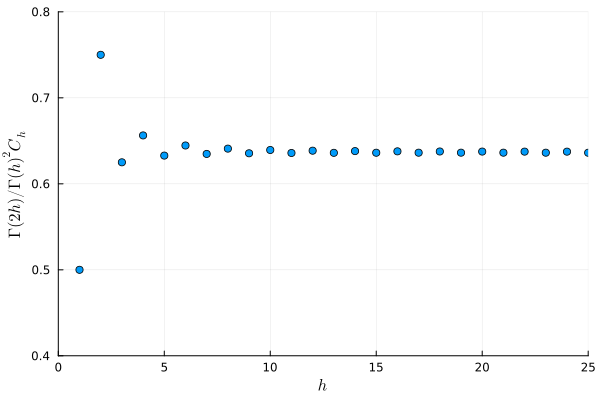

In [222]:
scatter([gamma(2*h) / gamma(h)^2 for h = 1:hmax] .* OPE_coeffs[0.25], label="")
xlims!(0,hmax)
xlabel!(L"h")
ylims!(0.4,0.8)
ylabel!(L"\Gamma(2h) / \Gamma(h)^2 C_h")

Question: what is this limit? Can we get an analytic guess?

In [240]:
# plot(legendtitle = L"h_\phi")
# for hϕ ∈ [0.1, 0.2, 0.3, 0.4]
#    scatter!([gamma(2*h) / gamma(h)^2 for h = 1:hmax] .* OPE_coeffs[hϕ], label=hϕ)
# end
# xlims!(0,hmax)
# xlabel!(L"h")
# # ylims!(0.4,0.8)
# ylabel!(L"\Gamma(2h) / \Gamma(h)^2 C_h") 

In [239]:
# plot(legendtitle = L"h_\phi")
# for hϕ ∈ [0.6, 0.7, 0.8, 0.9]
#    scatter!([gamma(2*h) / gamma(h)^2 for h = 1:hmax] .* OPE_coeffs[hϕ], label=hϕ)
# end
# xlims!(0,hmax)
# xlabel!(L"h")
# # ylims!(0.4,0.8)
# ylabel!(L"\Gamma(2h) / \Gamma(h)^2 C_h") 

In [238]:
# plot(legendtitle = L"h_\phi")
# for hϕ ∈ [0.1, 0.2, 0.3, 0.4]
#    scatter!([gamma(2*h) / gamma(h)^2 * gamma(h-2*hϕ) / gamma(2*hϕ + h - 1) for h = 1:hmax] .* OPE_coeffs[hϕ], label=hϕ)
# end
# xlims!(0,hmax)
# xlabel!(L"h")
# # ylims!(0.4,0.8)
# ylabel!(L"\Gamma(2h) / \Gamma(h)^2 \Gamma(h - 2h_\phi) \ \Gamma(h + 2h_\phi - 1) C_h") 

In [237]:
# plot(legendtitle = L"h_\phi")
# for hϕ ∈ [0.6, 0.7, 0.8, 0.9]
#    scatter!([gamma(2*h) / gamma(h)^2 * gamma(h-2*hϕ) / gamma(2*hϕ + h - 1) for h = 1:hmax] .* OPE_coeffs[hϕ], label=hϕ)
# end
# xlims!(0,hmax)
# xlabel!(L"h")
# ylims!(-500,100)
# ylabel!(L"\Gamma(2h) / \Gamma(h)^2 \Gamma(h - 2h_\phi) \ \Gamma(h + 2h_\phi - 1) C_h") 

In [236]:
# plot(legendtitle = L"h")
# for h = 1:3
#     scatter!(hϕ_table_noint, [OPE_coeffs[hϕ][h] for hϕ ∈ hϕ_table_noint], label = h)
# end
# xlims!(0, 1)
# xlabel!(L"h_\phi")
# ylims!(0, 1)
# ylabel!(L"C_h")

In [235]:
# plot(legendtitle = L"h")
# for h = 1:3
#     scatter!(hϕ_table_noint, [OPE_coeffs[hϕ][h] for hϕ ∈ hϕ_table_noint], label = h)
# end
# xlims!(0, 0.5)
# xlabel!(L"h_\phi")
# ylims!(0, 1)
# ylabel!(L"C_h")

In [234]:
# plot(legendtitle = L"h")
# for h = 1:6
#     plot!(hϕ_table_noint, gamma(2*h) / gamma(h)^2 * [OPE_coeffs[hϕ][h] for hϕ ∈ hϕ_table_noint], label = h)
# end
# xlims!(0.5, 1)
# xlabel!(L"h_\phi")
# ylabel!(L"\Gamma(2h) / \Gamma(h)^2 C_h")

### Compare with Virasoro vacuum module

At $h = 1$, we observe $C_1^2 = 2h_\phi$:

In [232]:
C1(hϕ) = 2 * hϕ

C1 (generic function with 1 method)

In [257]:
hϕ_table_noint .=> [OPE_coeffs[hϕ][1] for hϕ ∈ hϕ_table_noint] ./ C1.(hϕ_table_noint)

18-element Vector{Pair{Float64, Float64}}:
 0.05 => 0.999999988800623
  0.1 => 0.9999999839767694
 0.15 => 0.9999999793416187
  0.2 => 0.9999999366183577
 0.25 => 0.9999995628506121
  0.3 => 0.9999968005713883
 0.35 => 0.9999789537977268
  0.4 => 0.9998817428241733
 0.45 => 0.9995149987472923
 0.55 => 1.0314387184903355
  0.6 => 1.5071781635789434
 0.65 => 7.235449023211754
  0.7 => 71.51957985893839
 0.75 => 868.4099238999025
  0.8 => -9861.019628315273
 0.85 => -3296.075219507166
  0.9 => -2311.2107395779944
 0.95 => -1726.8621833834839

At $h = 2$ the operator is the energy-momentum tensor and its OPE coefficient squared must be
$$C_{\phi\phi T}^2 = \frac{2 h_\phi^2}{c}$$
This lets us compute $c$, and we find $c = 1$.

This is consistent with the 4-state Potts model at $h_\phi = 1/4$ (4-state Potts model) [and the free Dirac fermion when $h_\phi = 1/2$?].

In [241]:
C2(hϕ) = 2 * hϕ^2

C2 (generic function with 1 method)

In [258]:
hϕ_table_noint .=> [OPE_coeffs[hϕ][2] for hϕ ∈ hϕ_table_noint] ./ C2.(hϕ_table_noint)

18-element Vector{Pair{Float64, Float64}}:
 0.05 => 1.00000031334831
  0.1 => 1.0000002082572288
 0.15 => 1.0000001652585644
  0.2 => 1.000000348598949
 0.25 => 1.0000017486038892
  0.3 => 1.0000095983129067
 0.35 => 1.0000481057119774
  0.4 => 1.0002069504280298
 0.45 => 1.0006466692761655
 0.55 => 0.9771354553226813
  0.6 => 0.7464107124705215
 0.65 => -0.9186010915297226
  0.7 => -9.074233849889497
 0.75 => 0.999951802870306
  0.8 => -1231.7522000731994
 0.85 => -774.7823433625822
  0.9 => -769.7368032697822
 0.95 => -726.5205583155131

At $h = 3$, we observe $C_3^2 = \frac{4}{3} h_\phi^3$:

In [244]:
C3(hϕ) = 4 / 3 * hϕ^3

C3 (generic function with 1 method)

In [259]:
hϕ_table_noint .=> [OPE_coeffs[hϕ][3] for hϕ ∈ hϕ_table_noint] ./ C3.(hϕ_table_noint)

18-element Vector{Pair{Float64, Float64}}:
 0.05 => 0.9999931415343912
  0.1 => 0.9999978695276648
 0.15 => 0.9999989510833486
  0.2 => 0.9999984629807284
 0.25 => 0.9999943169712235
  0.3 => 0.9999761817208472
 0.35 => 0.9999067943533008
  0.4 => 0.9996821807997419
 0.45 => 0.9992036333544132
 0.55 => 1.0189672754403014
  0.6 => 1.1831485959483736
 0.65 => 2.365162939547448
  0.7 => 11.074253656371258
 0.75 => 97.37902502306083
  0.8 => -1077.659062182542
 0.85 => -421.11703707293987
  0.9 => -370.09577063809354
 0.95 => -348.4021211498053

At $h = 4$ the computation using the Virasoro algebra yields
$$C_4^2 = \frac{2 h_\phi^2 (1 + 5h_\phi)^2}{5c (5c + 22)}$$
or with $c = 1$,
$$C_4^2 = \frac{2 h_\phi^2 (1 + 5h_\phi)^2}{135}$$

In [260]:
C4(hϕ) = 2 / 135 * hϕ^2 * (1 + 5*hϕ)^2

C4 (generic function with 1 method)

In [261]:
hϕ_table_noint .=> [OPE_coeffs[hϕ][4] for hϕ ∈ hϕ_table_noint] ./ C4.(hϕ_table_noint)

18-element Vector{Pair{Float64, Float64}}:
 0.05 => 1.5120104199584996
  0.1 => 1.2000042480546955
 0.15 => 1.0653082957558253
  0.2 => 1.0125030590745068
 0.25 => 1.0000104920669006
  0.3 => 1.008040084081679
 0.35 => 1.0265879789904573
  0.4 => 1.0504346090254413
 0.45 => 1.076717710607726
 0.55 => 1.1093421448365595
  0.6 => 0.9962137700996305
 0.65 => 0.24506559402733957
  0.7 => -2.829765309989261
 0.75 => 1.221253383718136
  0.8 => -398.1683167751131
 0.85 => -245.72227808413044
  0.9 => -250.96143049881337
 0.95 => -251.20319670559184

In [249]:
C6(hϕ) = hϕ^2 * (17 + 140*hϕ + 1736*hϕ^2 - 840*hϕ^3 + 2772*hϕ^4) / 42525

C6 (generic function with 1 method)

In [262]:
hϕ_table_noint .=> [OPE_coeffs[hϕ][6] for hϕ ∈ hϕ_table_noint] ./ C6.(hϕ_table_noint)

18-element Vector{Pair{Float64, Float64}}:
 0.05 => 1.7330578550691027
  0.1 => 1.278923581267116
 0.15 => 1.0889007947262206
  0.2 => 1.0168859136675565
 0.25 => 1.0000262350871592
  0.3 => 1.0110352680644836
 0.35 => 1.0369015224370934
  0.4 => 1.070765312698644
 0.45 => 1.1084831351181783
 0.55 => 1.1668252377519088
  0.6 => 1.1024885649800704
 0.65 => 0.6585936876464836
  0.7 => -0.9668094626444093
 0.75 => 1.3110111232804382
  0.8 => -188.78015575573485
 0.85 => -113.0761049245253
  0.9 => -114.96269723603793
 0.95 => -115.92601501387546

In [263]:
C8(hϕ) = hϕ^2 * (3375 + 21210*hϕ + 490231*hϕ^2 + 198000*hϕ^3 + 510048*hϕ^4 + 640640*hϕ^5 + 782496*hϕ^6) / 227026800

C8 (generic function with 1 method)

In [264]:
hϕ_table_noint .=> [OPE_coeffs[hϕ][8] for hϕ ∈ hϕ_table_noint] ./ C8.(hϕ_table_noint)

18-element Vector{Pair{Float64, Float64}}:
 0.05 => 1.8591083130637345
  0.1 => 1.323402791326477
 0.15 => 1.102318213945686
  0.2 => 1.0194931491248012
 0.25 => 1.000048997896781
  0.3 => 1.012993188751045
 0.35 => 1.0437436001083393
  0.4 => 1.0843267454440895
 0.45 => 1.129527692032294
 0.55 => 1.2033595018329235
  0.6 => 1.1653113687422982
 0.65 => 0.867446005759418
  0.7 => -0.14492900683157045
 0.75 => 1.3581633714168428
  0.8 => -109.12563220239186
 0.85 => -63.71803272611757
  0.9 => -64.3445498601585
 0.95 => -64.87853601864455

**TODO**:
- complete the analysis of the OPE coefficients, with focus on the case $h_\phi > 1/4$
- can we get an analytic expression at large $h$? at least in the 4-state Potts model?
- include the cases where $h_\phi = 1/2$, and more generally when $2h_\phi$ is integer